In [3]:
import os
import whisper
import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = whisper.load_model("base").to(device)


100%|███████████████████████████████████████| 139M/139M [02:04<00:00, 1.17MiB/s]


In [5]:
def extract_whisper_embedding(audio_path):
    audio = whisper.load_audio(audio_path)
    audio = whisper.pad_or_trim(audio)
    mel = whisper.log_mel_spectrogram(audio).to(device)

    with torch.no_grad():
        encoded = model.encoder(mel.unsqueeze(0))
    
    return encoded.squeeze(0).mean(dim=0).cpu().numpy()


In [12]:
train_df = pd.read_csv("C:\\Users\\himan\\Downloads\\shl-intern-hiring-assessment\\dataset\\train.csv")
train_df['file_path'] = train_df['filename'].apply(lambda x: os.path.join("C:\\Users\\himan\\Downloads\\shl-intern-hiring-assessment\\dataset\\audios_train", x))

X = []
y = []

for i, row in tqdm(train_df.iterrows(), total=len(train_df)):
    try:
        emb = extract_whisper_embedding(row["file_path"])
        X.append(emb)
        y.append(row["label"])
    except Exception as e:
        print(f"Error processing {row['file']}: {e}")


  0%|          | 0/444 [00:00<?, ?it/s]

100%|██████████| 444/444 [04:44<00:00,  1.56it/s]


In [13]:
X = np.vstack(X)
y = np.array(y)


In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [15]:
reg = MLPRegressor(hidden_layer_sizes=(512, 256), activation='relu',
                   solver='adam', max_iter=500, random_state=42)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_val)


In [16]:
pearson_corr, _ = pearsonr(y_val, y_pred)
print("📈 Pearson Correlation:", round(pearson_corr, 4))


📈 Pearson Correlation: 0.7478


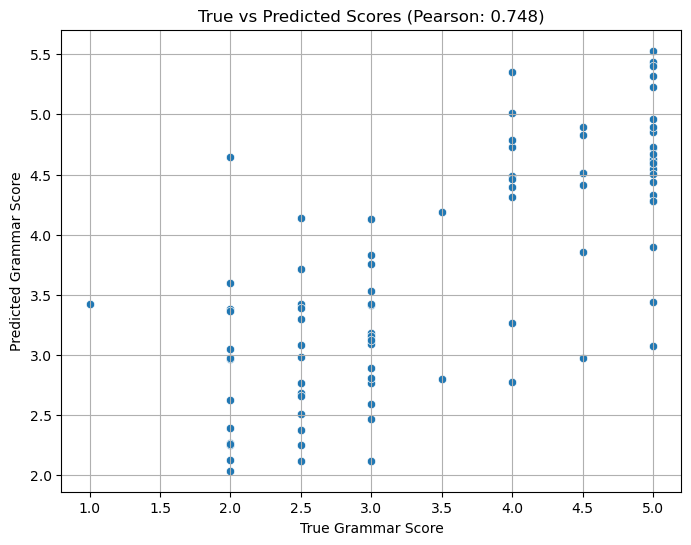

In [17]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=y_pred)
plt.xlabel("True Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title(f"True vs Predicted Scores (Pearson: {round(pearson_corr, 3)})")
plt.grid(True)
plt.show()


In [20]:
test_df = pd.read_csv("C:\\Users\\himan\\Downloads\\shl-intern-hiring-assessment\\dataset\\test.csv")
test_df['file_path'] = test_df['filename'].apply(lambda x: os.path.join("C:\\Users\\himan\\Downloads\\shl-intern-hiring-assessment\\dataset\\audios_test", x))

test_features = []

for file in tqdm(test_df["file_path"]):
    try:
        emb = extract_whisper_embedding(file)
        test_features.append(emb)
    except:
        test_features.append(np.zeros_like(X[0]))  # fallback

test_features = np.vstack(test_features)
test_preds = reg.predict(test_features)


100%|██████████| 195/195 [02:09<00:00,  1.51it/s]


In [28]:
import pandas as pd
import os

# Load the sample submission file to get correct format and order
sample_submission_path = "C:\\Users\\himan\\Downloads\\shl-intern-hiring-assessment\\dataset\\sample_submission.csv"
submission = pd.read_csv(sample_submission_path)

# Ensure your predictions (e.g., test_preds) have 195 entries
assert len(test_preds) == 195, f"Expected 195 predictions, but got {len(test_preds)}"

# Insert predictions
submission['label'] = test_preds

# Save to CSV (without index)
submission.to_csv("submission.csv", index=False)

# Confirm the file location
print("✅ Submission saved at:", os.path.abspath("submission.csv"))


df = pd.read_csv("submission.csv")
print(df.head())           # See first few rows
print(df.shape)            # Should print: (195, 2)


✅ Submission saved at: c:\Users\himan\AppData\Local\Programs\Microsoft VS Code\submission.csv
         filename     label
0   audio_706.wav  3.049326
1   audio_800.wav  2.873023
2    audio_68.wav  3.325507
3  audio_1267.wav  2.631489
4   audio_683.wav  2.153751
(195, 2)
